In [1]:
import os, sys, time, re, pickle, datetime as dt
import warnings
warnings.filterwarnings("ignore")

import keras
from keras import regularizers
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate, Merge, Conv2D, MaxPooling2D
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
vc_color = '#B5C9EB'

Using TensorFlow backend.


In [2]:
# DATA_DIR = "../data/raw/"
# TRAIN_DIR = DATA_DIR + "color_train/"
# VAL_DIR = DATA_DIR + "color_validation/"
# EXPORT_DIR = "../models/"

In [3]:
# For compatibility with folder structure on BR's computer
DATA_DIR = "../data/raw/plant_diseases/color/30_70_hr"
TRAIN_DIR = DATA_DIR + "/train/"
VAL_DIR = DATA_DIR + "/validation/"
EXPORT_DIR = "../models/"

In [4]:
IM_WIDTH, IM_HEIGHT = 64, 64
BATCH_SIZE = 16

In [5]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
superclasses = list(set([x.split("_")[0] for x in classes]))
superclasses.sort()
num_classes = len(classes)
num_superclasses = len(superclasses)

# Get path and label for each image
db = []
for label, class_name in enumerate(classes):
    
    superclass_name = class_name.split("_")[0]
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'superclass', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

In [6]:
db.head()

,file,label,class_name,superclass,train_ind
0,Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78...,0,Apple___Apple_scab,Apple,1
1,Apple___Apple_scab/0340dc35-5215-48ab-8db7-06a...,0,Apple___Apple_scab,Apple,1
2,Apple___Apple_scab/058d5e64-2c57-45ba-94cb-ac8...,0,Apple___Apple_scab,Apple,1
3,Apple___Apple_scab/06cf74b6-d895-4a09-b3b1-bc6...,0,Apple___Apple_scab,Apple,1
4,Apple___Apple_scab/0812e1e4-6d1b-4264-8f23-651...,0,Apple___Apple_scab,Apple,1


In [7]:
# Specify data generator inputs
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1/255)

In [8]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)

Found 16216 images belonging to 38 classes.
Found 38089 images belonging to 38 classes.


In [9]:
class_id2superclass_id = np.array([superclasses.index(x.split("_")[0]) for x in classes])

def wills_two_label_generator(existing_generator, class_id2superclass_id):
    for x_data, class_one_hots in existing_generator:
        #look up superclass ids
        superclass_ids = np.dot(class_one_hots,class_id2superclass_id)
        #one-hot-encode
        batch_size = superclass_ids.shape[0]
        superclass_one_hots = np.zeros((batch_size, num_superclasses))
        superclass_one_hots[np.arange(batch_size), superclass_ids.astype(int)] = 1

        yield(x_data, {'class_output': class_one_hots, 'superclass_output': superclass_one_hots} )

In [10]:
# Initiate optimizer
opt = keras.optimizers.adam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, cooldown=5)

In [43]:
def plot_history(history, ax, categories, labels, yaxis_label = 'Accuracy'):
    for cat, lab in zip(categories, labels):
        ax.plot(history[cat], label=lab)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(yaxis_label)
    ax.legend(loc='best')

## Build Low-Parameter Superclass Model

In [12]:
main_input_super = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_leaf_0 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super)
pooled_leaf_0 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_0)

#leaf block 1
conv_leaf_1 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1)
dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_1_2 = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_0)
pooled_disease_1 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_1_2)
dropped_disease_1 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_1)

#dense layer to predict leaf [plant type]
flat_leaf = Flatten()(dropped_leaf_1)
dense_leaf_1 = Dense(32, activation = 'relu')(flat_leaf) # Using less layers here as accuracy is less important
dense_leaf_drop = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_1)
leaf_prediction = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop)

# dense layer to predict disease [plant type+disease type]
flat_disease_super = Flatten()(dropped_disease_1)
dense_disease_super = Dense(64, activation = 'relu')(flat_disease_super)

# combine networks and perform final categorization
combined_dense_disease = concatenate([dense_disease_super, leaf_prediction], axis=-1, name='final_combination')
dense_disease_drop = Dropout(0.3, name='final_drop')(combined_dense_disease)
disease_prediction = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop)
model_superclass = Model(inputs=[main_input_super], outputs=[disease_prediction, leaf_prediction])

In [13]:
# Compile model
model_superclass.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_superclass.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
shared_conv (Conv2D)            (None, 62, 62, 32)   896         image_input[0][0]                
__________________________________________________________________________________________________
shared_pool (MaxPooling2D)      (None, 31, 31, 32)   0           shared_conv[0][0]                
__________________________________________________________________________________________________
leaf_conv (Conv2D)              (None, 29, 29, 16)   4624        shared_pool[0][0]                
__________________________________________________________________________________________________
leaf_pool 

In [14]:
# Set up callbacks
model_name = "superclass_model"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [15]:
# Fit generator
results = model_superclass.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id), epochs=40, steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id), validation_steps=500,
    callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 137s 273ms/step - loss: 5.1243 - class_output_loss: 2.9440 - superclass_output_loss: 2.1803 - class_output_acc: 0.2335 - superclass_output_acc: 0.3513 - val_loss: 4.2869 - val_class_output_loss: 2.4180 - val_superclass_output_loss: 1.8689 - val_class_output_acc: 0.3688 - val_superclass_output_acc: 0.4073
Epoch 2/40
500/500 [==============================] - 204s 408ms/step - loss: 4.2969 - class_output_loss: 2.3744 - superclass_output_loss: 1.9224 - class_output_acc: 0.3458 - superclass_output_acc: 0.4071 - val_loss: 3.6810 - val_class_output_loss: 1.9690 - val_superclass_output_loss: 1.7120 - val_class_output_acc: 0.4464 - val_superclass_output_acc: 0.4410
Epoch 3/40
500/500 [==============================] - 210s 421ms/step - loss: 3.8358 - class_output_loss: 2.0720 - superclass_output_loss: 1.7638 - class_output_acc: 0.4123 - superclass_output_acc: 0.4409 - val_loss: 3.1949 - val_class_output_loss: 1.6633 - val_superclass_output_

Epoch 24/40
500/500 [==============================] - 151s 302ms/step - loss: 2.3938 - class_output_loss: 1.1044 - superclass_output_loss: 1.2894 - class_output_acc: 0.6635 - superclass_output_acc: 0.5763 - val_loss: 1.7169 - val_class_output_loss: 0.7990 - val_superclass_output_loss: 0.9180 - val_class_output_acc: 0.7484 - val_superclass_output_acc: 0.6850
Epoch 25/40
500/500 [==============================] - 141s 282ms/step - loss: 2.4002 - class_output_loss: 1.1039 - superclass_output_loss: 1.2963 - class_output_acc: 0.6644 - superclass_output_acc: 0.5695 - val_loss: 1.9734 - val_class_output_loss: 0.9940 - val_superclass_output_loss: 0.9794 - val_class_output_acc: 0.6929 - val_superclass_output_acc: 0.6619
Epoch 26/40
500/500 [==============================] - 129s 259ms/step - loss: 2.3417 - class_output_loss: 1.0720 - superclass_output_loss: 1.2696 - class_output_acc: 0.6735 - superclass_output_acc: 0.5830 - val_loss: 1.7768 - val_class_output_loss: 0.8395 - val_superclass_outp

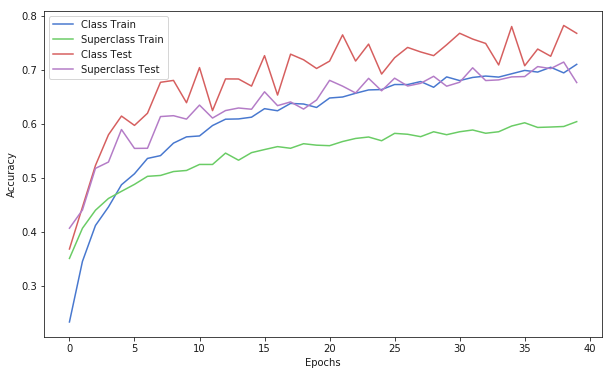

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_acc', 'superclass_output_acc', 'val_class_output_acc', 'val_superclass_output_acc'],
             ['Class Train', 'Superclass Train', 'Class Test', 'Superclass Test'])

In [31]:
with open('./train_history/superclass_lowparams.hist', 'wb') as file_pi:
        pickle.dump(results.history, file_pi)

## Build Low-Parameter Baseline Model

In [26]:
# Already defined
main_input_base = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base)
pooled_leaf_base = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base)


# Not using
# #leaf block 1
# conv_leaf_1_2 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
# pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1_2)
# dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_base = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base)
pooled_disease_base = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base)
dropped_disease_base = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base)

# dense layer to predict disease [plant type+disease type]
flat_disease_base = Flatten()(dropped_disease_base)
dense_disease_base = Dense(64, activation = 'relu')(flat_disease_base)
dense_disease_base_drop = Dropout(0.3)(dense_disease_base)

disease_prediction_base = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop)
model_base = Model(inputs=[main_input_base], outputs=[disease_prediction_base])

In [27]:
model_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [28]:
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
shared_conv (Conv2D)         (None, 62, 62, 32)        896       
_________________________________________________________________
shared_pool (MaxPooling2D)   (None, 31, 31, 32)        0         
_________________________________________________________________
disease_conv (Conv2D)        (None, 29, 29, 64)        18496     
_________________________________________________________________
disease_pool (MaxPooling2D)  (None, 14, 14, 64)        0         
_________________________________________________________________
disease_conv_drop (Dropout)  (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
__________

In [29]:
# Set up callbacks
model_name = "base_of_superclass_lowparams"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [30]:
# Fit generator
results_base = model_base.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 108s 215ms/step - loss: 3.0880 - acc: 0.2009 - val_loss: 2.7666 - val_acc: 0.2614

Epoch 00001: val_acc improved from -inf to 0.26138, saving model to ../models/base_of_superclass_lowparams.hdf5
Epoch 2/40
500/500 [==============================] - 111s 223ms/step - loss: 2.7683 - acc: 0.2546 - val_loss: 2.4899 - val_acc: 0.3103

Epoch 00002: val_acc improved from 0.26138 to 0.31025, saving model to ../models/base_of_superclass_lowparams.hdf5
Epoch 3/40
500/500 [==============================] - 113s 225ms/step - loss: 2.5538 - acc: 0.2999 - val_loss: 2.2001 - val_acc: 0.3847

Epoch 00003: val_acc improved from 0.31025 to 0.38475, saving model to ../models/base_of_superclass_lowparams.hdf5
Epoch 4/40
500/500 [==============================] - 126s 252ms/step - loss: 2.3712 - acc: 0.3488 - val_loss: 2.0517 - val_acc: 0.3990

Epoch 00004: val_acc improved from 0.38475 to 0.39900, saving model to ../models/base_of_superclass_lowparams.

500/500 [==============================] - 104s 209ms/step - loss: 1.1869 - acc: 0.6334 - val_loss: 1.0751 - val_acc: 0.6761

Epoch 00039: val_acc improved from 0.67100 to 0.67612, saving model to ../models/base_of_superclass_lowparams.hdf5
Epoch 40/40
500/500 [==============================] - 109s 219ms/step - loss: 1.1679 - acc: 0.6427 - val_loss: 1.1314 - val_acc: 0.6689

Epoch 00040: val_acc did not improve


In [32]:
with open('./train_history/baseclass_lowparams.hist', 'wb') as file_pi:
        pickle.dump(results_base.history, file_pi)

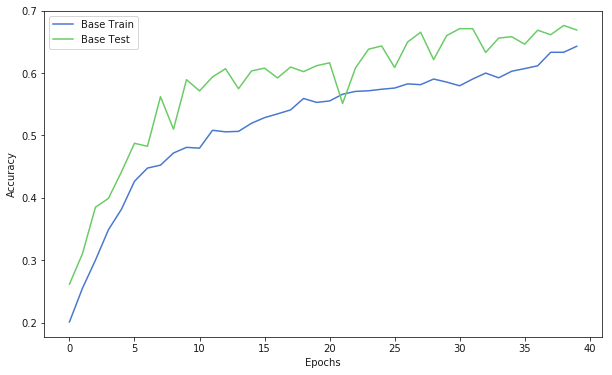

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base.history, ax,
             ['acc', 'val_acc'],
             ['Base Train', 'Base Test'])

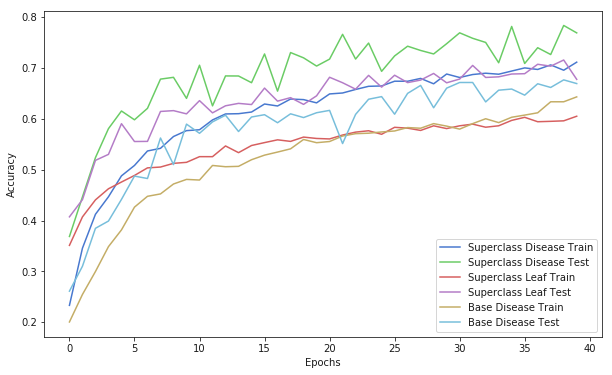

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_acc', 'val_class_output_acc', 'superclass_output_acc', 'val_superclass_output_acc'],
             ['Superclass Disease Train', 'Superclass Disease Test', 'Superclass Leaf Train', 'Superclass Leaf Test'])
plot_history(results_base.history, ax,
             ['acc', 'val_acc'],
             ['Base Disease Train', 'Base Disease Test'])

fig.savefig("./images/superclass_comparison_lowres_full.png")

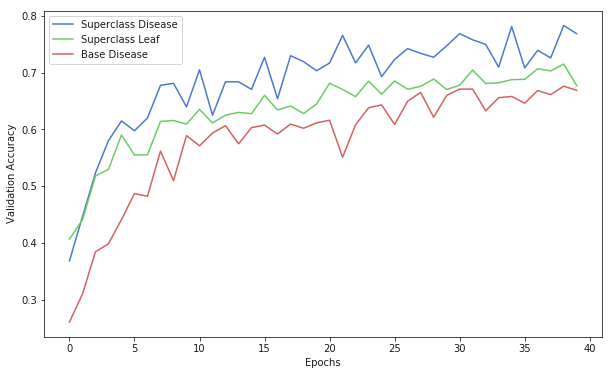

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['val_class_output_acc', 'val_superclass_output_acc'],
             ['Superclass Disease', 'Superclass Leaf'])
plot_history(results_base.history, ax,
             ['val_acc'],
             ['Base Disease'], yaxis_label="Validation Accuracy")

fig.savefig("./images/superclass_comparison_lowres.png")

## Build High-Parameter Baseline Model

In [47]:
# Already defined
main_input_base2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base2)
pooled_leaf_base2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base2)

#disease block 1
conv_disease_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base2)
pooled_disease_base2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base2)
dropped_disease_base2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base2)

# dense layer to predict disease [plant type+disease type]
flat_disease_base2 = Flatten()(dropped_disease_base2)
dense_disease_base2 = Dense(128, activation = 'relu')(flat_disease_base2)
dense_disease_base_drop2 = Dropout(0.3)(dense_disease_base2)

disease_prediction_base2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop2)
model_base2 = Model(inputs=[main_input_base2], outputs=[disease_prediction_base2])

In [48]:
model_base2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
shared_conv (Conv2D)         (None, 62, 62, 128)       3584      
_________________________________________________________________
shared_pool (MaxPooling2D)   (None, 31, 31, 128)       0         
_________________________________________________________________
disease_conv (Conv2D)        (None, 29, 29, 128)       147584    
_________________________________________________________________
disease_pool (MaxPooling2D)  (None, 14, 14, 128)       0         
_________________________________________________________________
disease_conv_drop (Dropout)  (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
__________

In [51]:
model_base2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [52]:
# Set up callbacks
model_name = "base_of_superclass_highparam_model"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)
callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [53]:
# Fit generator
results_base2 = model_base2.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 235s 470ms/step - loss: 2.9807 - acc: 0.2240 - val_loss: 2.5368 - val_acc: 0.3182

Epoch 00001: val_acc improved from -inf to 0.31825, saving model to ../models/base_of_superclass_highparam_model.hdf5
Epoch 2/40
500/500 [==============================] - 234s 468ms/step - loss: 2.4574 - acc: 0.3371 - val_loss: 2.0069 - val_acc: 0.4574

Epoch 00002: val_acc improved from 0.31825 to 0.45737, saving model to ../models/base_of_superclass_highparam_model.hdf5
Epoch 3/40
500/500 [==============================] - 230s 460ms/step - loss: 2.1352 - acc: 0.4106 - val_loss: 1.9613 - val_acc: 0.4571

Epoch 00003: val_acc did not improve
Epoch 4/40
500/500 [==============================] - 253s 505ms/step - loss: 2.0064 - acc: 0.4481 - val_loss: 1.7045 - val_acc: 0.5254

Epoch 00004: val_acc improved from 0.45737 to 0.52538, saving model to ../models/base_of_superclass_highparam_model.hdf5
Epoch 5/40
500/500 [==============================] - 2


Epoch 00039: val_acc did not improve
Epoch 40/40
500/500 [==============================] - 223s 445ms/step - loss: 0.9614 - acc: 0.7016 - val_loss: 0.8638 - val_acc: 0.7255

Epoch 00040: val_acc did not improve


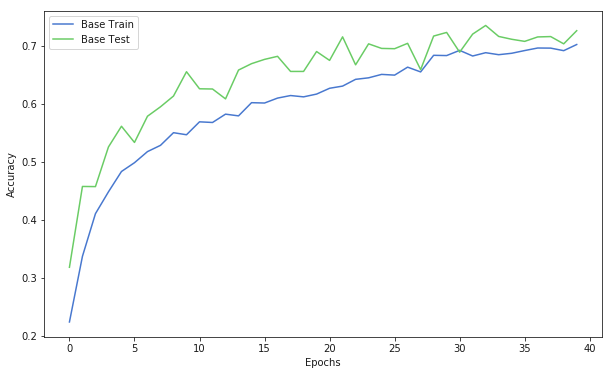

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base2.history, ax,
             ['acc', 'val_acc'],
             ['Base Train', 'Base Test'])

In [60]:
with open('./train_history/baseclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_base2.history, file_pi)

## Build High-Parameter Baseline Model

In [62]:
main_input_super2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super2)
pooled_super2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_super2)

#leaf block 1
conv_leaf_super2 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_super2)
pooled_leaf_super2 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_super2)
dropped_leaf_super2 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_super2)

#disease block 1
conv_disease_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_super2)
pooled_disease_super2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_super2)
dropped_disease_super2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_super2)

#dense layer to predict leaf [plant type]
flat_leaf_super2 = Flatten()(dropped_leaf_super2)
dense_leaf_super2 = Dense(64, activation = 'relu')(flat_leaf_super2) # Using less layers here as accuracy is less important
dense_leaf_drop_super2 = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_super2)
leaf_prediction_super2 = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop_super2)

# dense layer to predict disease [plant type+disease type]
flat_disease_super2 = Flatten()(dropped_disease_super2)
dense_disease_super2 = Dense(128, activation = 'relu')(flat_disease_super2)

# combine networks and perform final categorization
combined_dense_disease_super2 = concatenate([dense_disease_super2, leaf_prediction_super2], axis=-1, name='final_combined')
dense_disease_drop_super2 = Dropout(0.3, name='final_drop')(combined_dense_disease_super2)

disease_prediction_super2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop_super2)
model_superclass_2 = Model(inputs=[main_input_super2], outputs=[disease_prediction_super2, leaf_prediction_super2])

In [63]:
model_superclass_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
shared_conv (Conv2D)            (None, 62, 62, 128)  3584        image_input[0][0]                
__________________________________________________________________________________________________
shared_pool (MaxPooling2D)      (None, 31, 31, 128)  0           shared_conv[0][0]                
__________________________________________________________________________________________________
leaf_conv (Conv2D)              (None, 29, 29, 32)   36896       shared_pool[0][0]                
__________________________________________________________________________________________________
leaf_pool 

In [64]:
# Compile model
model_superclass_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [65]:
# Set up callbacks
model_name = "superclass_model_highparams"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [61]:
# Fit generator
results_superclass2 = model_superclass_2.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id),
    epochs=40,
    steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id),
    validation_steps=500,
    callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 309s 617ms/step - loss: 3.7585 - class_output_loss: 2.1540 - superclass_output_loss: 1.6045 - class_output_acc: 0.4075 - superclass_output_acc: 0.4964 - val_loss: 3.4000 - val_class_output_loss: 1.9284 - val_superclass_output_loss: 1.4715 - val_class_output_acc: 0.4786 - val_superclass_output_acc: 0.5146
Epoch 2/40
500/500 [==============================] - 298s 597ms/step - loss: 3.7543 - class_output_loss: 2.1550 - superclass_output_loss: 1.5993 - class_output_acc: 0.4080 - superclass_output_acc: 0.5055 - val_loss: 3.3991 - val_class_output_loss: 1.9614 - val_superclass_output_loss: 1.4376 - val_class_output_acc: 0.4690 - val_superclass_output_acc: 0.5312
Epoch 3/40
500/500 [==============================] - 293s 586ms/step - loss: 3.7269 - class_output_loss: 2.1401 - superclass_output_loss: 1.5869 - class_output_acc: 0.4151 - superclass_output_acc: 0.5021 - val_loss: 3.3327 - val_class_output_loss: 1.9394 - val_superclass_output_

KeyboardInterrupt: 

In [17]:
# Fit generator
results_superclass2 = model_superclass_2.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id),
    epochs=40,
    steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id),
    validation_steps=500,
    callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 279s 557ms/step - loss: 4.9593 - class_output_loss: 2.9186 - superclass_output_loss: 2.0407 - class_output_acc: 0.2362 - superclass_output_acc: 0.3853 - val_loss: 3.8801 - val_class_output_loss: 2.1421 - val_superclass_output_loss: 1.7380 - val_class_output_acc: 0.4319 - val_superclass_output_acc: 0.4279
Epoch 2/40
500/500 [==============================] - 275s 549ms/step - loss: 4.0308 - class_output_loss: 2.3168 - superclass_output_loss: 1.7140 - class_output_acc: 0.3546 - superclass_output_acc: 0.4615 - val_loss: 3.1737 - val_class_output_loss: 1.8365 - val_superclass_output_loss: 1.3373 - val_class_output_acc: 0.4721 - val_superclass_output_acc: 0.5859
Epoch 3/40
500/500 [==============================] - 304s 608ms/step - loss: 3.3676 - class_output_loss: 1.9005 - superclass_output_loss: 1.4671 - class_output_acc: 0.4527 - superclass_output_acc: 0.5258 - val_loss: 3.1183 - val_class_output_loss: 1.8915 - val_superclass_output_

Epoch 24/40
500/500 [==============================] - 265s 530ms/step - loss: 1.6905 - class_output_loss: 0.8359 - superclass_output_loss: 0.8547 - class_output_acc: 0.7396 - superclass_output_acc: 0.7238 - val_loss: 1.2439 - val_class_output_loss: 0.6396 - val_superclass_output_loss: 0.6043 - val_class_output_acc: 0.7993 - val_superclass_output_acc: 0.8072
Epoch 25/40
500/500 [==============================] - 271s 542ms/step - loss: 1.7036 - class_output_loss: 0.8512 - superclass_output_loss: 0.8524 - class_output_acc: 0.7381 - superclass_output_acc: 0.7236 - val_loss: 1.3776 - val_class_output_loss: 0.7335 - val_superclass_output_loss: 0.6441 - val_class_output_acc: 0.7745 - val_superclass_output_acc: 0.7964
Epoch 26/40
500/500 [==============================] - 260s 520ms/step - loss: 1.6313 - class_output_loss: 0.8110 - superclass_output_loss: 0.8203 - class_output_acc: 0.7494 - superclass_output_acc: 0.7351 - val_loss: 1.5136 - val_class_output_loss: 0.8069 - val_superclass_outp

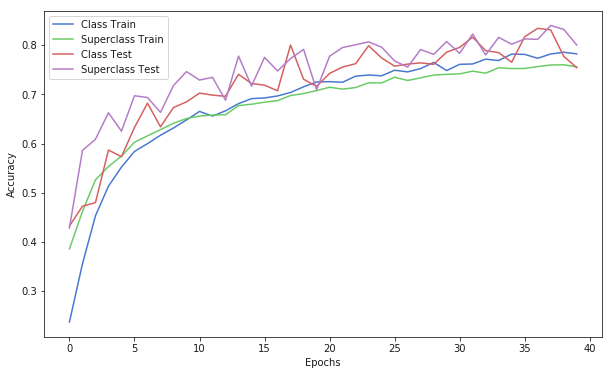

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
plot_learning_curve(results_superclass2, ax)

In [28]:
with open('./train_history/superclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_superclass2.history, file_pi)

In [30]:
results_superclass2_load = pickle.load( open('./train_history/superclass_highparams.hist', "rb" ) )

In [33]:
type(results_superclass2.history)

dict

In [36]:
results_superclass2_load.keys()

dict_keys(['val_loss', 'val_class_output_loss', 'val_superclass_output_loss', 'val_class_output_acc', 'val_superclass_output_acc', 'loss', 'class_output_loss', 'superclass_output_loss', 'class_output_acc', 'superclass_output_acc', 'lr'])

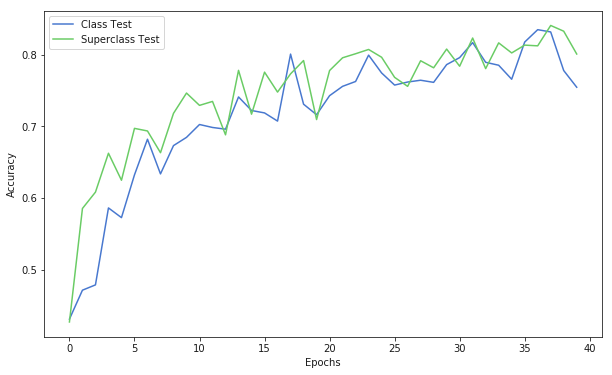

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_superclass2_load, ax, 
             categories=['val_class_output_acc', 'val_superclass_output_acc'], 
             labels=['Class Test', 'Superclass Test'])